#### Copyright 2020 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Embeddings

Embeddings are a powerful way to represent data for deep learning models.

In this exercise we will work specifically with embeddings of words. This is one of the most common applications of this technique. We will train word embeddings from scratch on a small dataset and visualize those embeddings.

Embeddings can be trained using either supervised or unsupervised learning. For this exercise we will train a supervised sentiment classifier on IMDB movie reviews. We will learn our own word embeddings in the process.

## Setup

First we will set random seeds for reproducible results. Controlling which random numbers are generated ensures we get the same results every time we run this lab. **This should almost never be used in production code.**

In [ ]:
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

## The Dataset

We will use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). This dataset is conveniently packaged in TensorFlow Keras. 

In [ ]:
from tensorflow import keras

imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data()

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

((25000,), (25000,), (25000,), (25000,))

The reviews have been pre-processed, so the text of each review (a list of words) has been converted to a list of integers, and each integer represents a specific word.

In [ ]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


There are also some special placeholder characters. For instance, each review starts with a `start_char` placeholder that defaults to a value of `1`.

In [ ]:
{review[0]: 'start_char' for review in train_data}

{1: 'start_char'}

Each sentiment label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review. Thus this is a binary classification problem.

In [ ]:
train_labels[0]

1

### Word Index

It is useful to be able to convert a list of integers back to text. The `imdb.get_word_index()` returns a dictionary of all of the words in the reviews. The words have a numeric value that represents their frequency in the dataset.

For instance, if we wanted to find the `25` most common words in the reviews, we could use the code below:

In [ ]:
top_25 = ['' for _ in range(25)]
top_25

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [ ]:
top_25 = ['' for _ in range(25)]
for k, v  in imdb.get_word_index().items():
  if v <= 25:
    top_25[v-1] = k

top_25

['the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'br',
 'in',
 'it',
 'i',
 'this',
 'that',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'you',
 'are',
 'his',
 'have']

You can see that these words probably aren't helpful for predicting sentiment. The `skip_top=n` argument can be passed to [`load_data`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) to skip over the `n` most common words.

Let's reload our data using `skip_top`.

In [ ]:
from tensorflow import keras

imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    skip_top=25,
)

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

((25000,), (25000,), (25000,), (25000,))

Our data now doesn't include the top `25` words in the reviews. That begs the question: what happens to these words? Are they removed? Are they replaced?

It turns out they are replaced by a placeholder value. This value is the `oov_char`, which by default is `2`.

If we print out the first training review we can see that the top `25` most common words are now replaced with `2`, including the `start_char`!

In [ ]:
train_data[0]

[2,
 2,
 2,
 2,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 36,
 256,
 2,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 2,
 35,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 2,
 172,
 4536,
 1111,
 2,
 546,
 38,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 43,
 530,
 38,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 19193,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 5244,
 2,
 480,
 66,
 3785,
 33,
 2,
 130,
 2,
 2,
 38,
 619,
 2,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 2,
 2,
 2,
 215,
 28,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 10311,
 2,
 2,
 107,
 117,
 5952,
 2,
 256,
 2,
 31050,
 2,
 3766,
 2,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 2,
 2,
 12118,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 2,
 194,
 7486,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 26,
 480,
 2,
 144,
 30,
 5535,
 2,
 51,
 36,


Let's create a function that can convert a numeric review into text so we can read the reviews ourselves.

To do this we need to modify the word index a bit. The index from Keras starts at `1`, but we know that the `start_char` is `1` and that the `oov_char` is `2`. We need to shift the indexes by a few values.

The `load_data` function has an argument called `index_from` that defaults to `3`. The reviews are indexed with the first word starting at `3`, while the word index has the first word starting at `1`. Let's fix that and add placeholders for start, oov, and a padding character we'll use to make the reviews equal-sized for modeling.

In [ ]:
# A dictionary mapping each word to an integer index.
word_index = imdb.get_word_index()

# Reserve the first 3 indices for special tokens.
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<OOV>"] = 2

vocab_size = len(word_index)
print('# unique words: {}'.format(vocab_size))

# unique words: 88587


And now let's try to decode a review.

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[0])

"<OOV> <OOV> <OOV> <OOV> just brilliant casting location scenery story direction everyone's really suited <OOV> part they played <OOV> you could just imagine being there robert redford's <OOV> an amazing actor <OOV> now <OOV> same being director norman's father came from <OOV> same scottish island <OOV> myself so <OOV> loved <OOV> fact there <OOV> <OOV> real connection <OOV> <OOV> <OOV> <OOV> witty remarks throughout <OOV> <OOV> were great <OOV> <OOV> just brilliant so much <OOV> <OOV> bought <OOV> <OOV> <OOV> soon <OOV> <OOV> <OOV> released <OOV> retail <OOV> would recommend <OOV> <OOV> everyone <OOV> watch <OOV> <OOV> fly fishing <OOV> amazing really cried at <OOV> end <OOV> <OOV> so sad <OOV> you know what they say if you cry at <OOV> <OOV> <OOV> must have been good <OOV> <OOV> definitely <OOV> also congratulations <OOV> <OOV> two little boy's <OOV> played <OOV> part's <OOV> norman <OOV> paul they were just brilliant children are often left out <OOV> <OOV> praising list <OOV> think 

### Preprocessing

Movie reviews can be different lengths, but inputs to a neural network must all be the same length. Let's take a look at the distribution of review lengths.

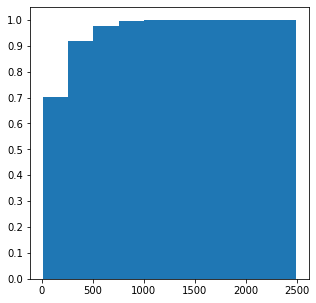

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
review_lengths = [len(review) for review in train_data]
plt.hist(review_lengths, density=True, cumulative=True)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.show()

Even though the longest review is close to `2500` words long, many of the reviews have fewer than 500 words. 

We can use the `pad_sequences` function to standardize the lengths of the reviews to `500` words long. Any reviews longer than this will have the extra words truncated, while any reviews shorter than `500` words will have extra `"<PAD>"` tokens added to the end. 

Choosing a standardized length requires balancing efficiency (longer lengths mean slower training) and information loss (shorter lengths may truncate too much valuable information). Aiming for a length that fully covers `90%` of samples is generally reasonable, and you can further tune this as a hyperparameter.

In [ ]:
maxlen = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, value=word_index["<PAD>"], padding='post', maxlen=maxlen)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, value=word_index["<PAD>"], padding='post', maxlen=maxlen)

Let's inspect the first padded review.

In [ ]:
print(decode_review(train_data[0]))

<OOV> <OOV> <OOV> <OOV> just brilliant casting location scenery story direction everyone's really suited <OOV> part they played <OOV> you could just imagine being there robert redford's <OOV> an amazing actor <OOV> now <OOV> same being director norman's father came from <OOV> same scottish island <OOV> myself so <OOV> loved <OOV> fact there <OOV> <OOV> real connection <OOV> <OOV> <OOV> <OOV> witty remarks throughout <OOV> <OOV> were great <OOV> <OOV> just brilliant so much <OOV> <OOV> bought <OOV> <OOV> <OOV> soon <OOV> <OOV> <OOV> released <OOV> retail <OOV> would recommend <OOV> <OOV> everyone <OOV> watch <OOV> <OOV> fly fishing <OOV> amazing really cried at <OOV> end <OOV> <OOV> so sad <OOV> you know what they say if you cry at <OOV> <OOV> <OOV> must have been good <OOV> <OOV> definitely <OOV> also congratulations <OOV> <OOV> two little boy's <OOV> played <OOV> part's <OOV> norman <OOV> paul they were just brilliant children are often left out <OOV> <OOV> praising list <OOV> think b

## Build the Model

### Using the Embedding Layer

Keras makes it easy to use embeddings. The [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer takes at least two arguments: the number of possible words in the vocabulary and the dimensionality of the embeddings. We will start by using a small embedding size of 2 to make visualization easier.

In [ ]:
embedding_dim = 2

embedding_layer = keras.layers.Embedding(vocab_size, embedding_dim)

The Embedding layer can be understood as a lookup table that maps from integer indices, which stand for specific words, to dense vectors (their embeddings). The dimensionality, or width, of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

When we create an Embedding layer, the weights for the embedding are randomly initialized just like any other layer. During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem our model is trained on).

As input, the Embedding layer takes a 2D tensor of integers, of shape `(num_samples, sequence_length)`, where each sample is a sequence of integers. As output, the embedding layer returns a 3D floating point tensor, of shape `(num_samples, sequence_length, embedding_dimensionality)`. 

### Configure the Model

1. The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch size, sequence length, embedding size)`.

1. Next, we flatten the output from a 2-d array to a 1-d array.

1. The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level, that the review is positive.

In [ ]:
model = keras.Sequential([
  keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 2)            177174    
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 178,175
Trainable params: 178,175
Non-trainable params: 0
_________________________________________________________________


### Compile and Train the model

In [ ]:
model.compile(
  # Calculate loss for a binary classification problem.
  loss='binary_crossentropy',

  # Adam is one of the most commonly used optimizers.
  optimizer=tf.keras.optimizers.Adam(),

  # We will only track accuracy for this task.
  metrics=['accuracy']
)

The number of epochs and batch size used during training are both hyperparameters, which means you may need to experiment with different values to improve performance. This also means there's no magic answer for which values to choose.

If you've implemented your model correctly, you should observe decreasing training loss within a few epochs. With more epochs (more training), the model will experience more overfitting. You will typically train for at least 5 epochs. For this model, we train for 10 epochs as a reasonable tradeoff between learning (as the validation accuracy is still increasing) and overfitting.

Since we have a fairly large dataset, we also want to process data in batches instead of the entire dataset at once. If we choose batch sizes that are too small, we will get slower training per epoch, while larger batch sizes may require more epochs to train and even cause out-of-memory errors. It's good practice to start with a small power of two (e.g., 32), and then experiment with continuously doubling your batch size. For this model, we are able to use a batch size of 512 with good performance.

In [ ]:
history = model.fit(
    train_data,
    train_labels,
    epochs=10,
    batch_size=512,
    validation_split=0.2
)

Epoch 1/10
40/40 [==============================] - 2s 22ms/step - loss: 0.6929 - accuracy: 0.5034 - val_loss: 0.6924 - val_accuracy: 0.5284
Epoch 2/10
40/40 [==============================] - 1s 18ms/step - loss: 0.6853 - accuracy: 0.6280 - val_loss: 0.6842 - val_accuracy: 0.6230
Epoch 3/10
40/40 [==============================] - 1s 18ms/step - loss: 0.6625 - accuracy: 0.7304 - val_loss: 0.6524 - val_accuracy: 0.7310
Epoch 4/10
40/40 [==============================] - 1s 18ms/step - loss: 0.6074 - accuracy: 0.8044 - val_loss: 0.5892 - val_accuracy: 0.7876
Epoch 5/10
40/40 [==============================] - 1s 18ms/step - loss: 0.5279 - accuracy: 0.8417 - val_loss: 0.5168 - val_accuracy: 0.8198
Epoch 6/10
40/40 [==============================] - 1s 18ms/step - loss: 0.4478 - accuracy: 0.8687 - val_loss: 0.4554 - val_accuracy: 0.8422
Epoch 7/10
40/40 [==============================] - 1s 17ms/step - loss: 0.3815 - accuracy: 0.8887 - val_loss: 0.4086 - val_accuracy: 0.8526
Epoch 8/10
40

Let's visualize the training and validation accuracy over time.

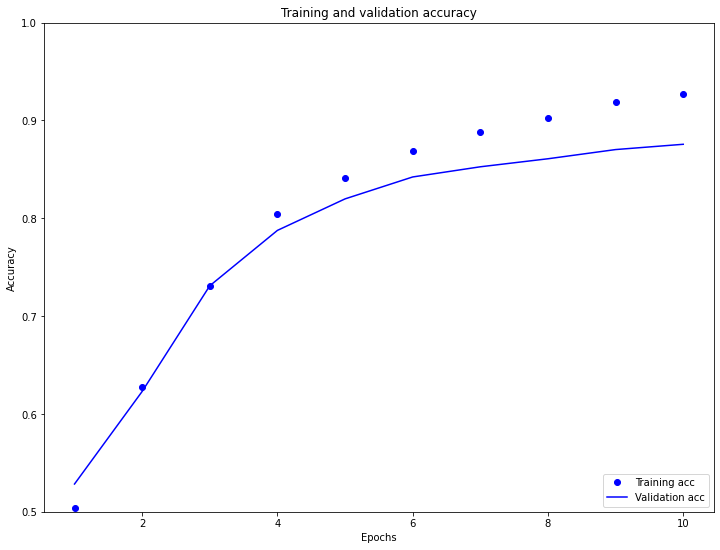

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))

plt.show()

With this approach, our model reaches a validation accuracy of around 87%. (Note that the model is already beginning to overfit, as reflected in the diverging training and validation accuracy curves.)

## Visualize Embeddings

### Retrieve the Learned Embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab size, embedding dimension)`.

In [ ]:
e = model.layers[0]
embedding_matrix = e.get_weights()[0]
print(embedding_matrix.shape)

(88587, 2)


Looking at all 80,000+ at once would be overwhelming, so let's explore the learned word embeddings on a small set of terms. Most of these terms are generally strongly indicative of sentiment, but some are added just for fun.

In [ ]:
informative_terms = [ "bad", "great", "best", "worst", "fun", "beautiful",
                      "excellent", "poor", "boring", "awful", "terrible",
                      "definitely", "perfect", "liked", "worse", "waste",
                      "entertaining", "loved", "unfortunately", "amazing",
                      "enjoyed", "favorite", "horrible", "brilliant", "highly",
                      "simple", "annoying", "today", "hilarious", "enjoyable",
                      "dull", "fantastic", "poorly", "fails", "disappointing",
                      "disappointment", "not", "him", "her", "good", "time",
                      "sad", "exciting", "slow", "movie", "film", "action",
                      "comedy", "drama", "fabulous"]

Now we plot each word in `informative_terms` on a two-dimensional graph. Recall that we are using two-dimensional embeddings, so consider the first value as an x-value and the second value as a y-value. 

*Note: If the displayed plot is too small, try running the cell again.*

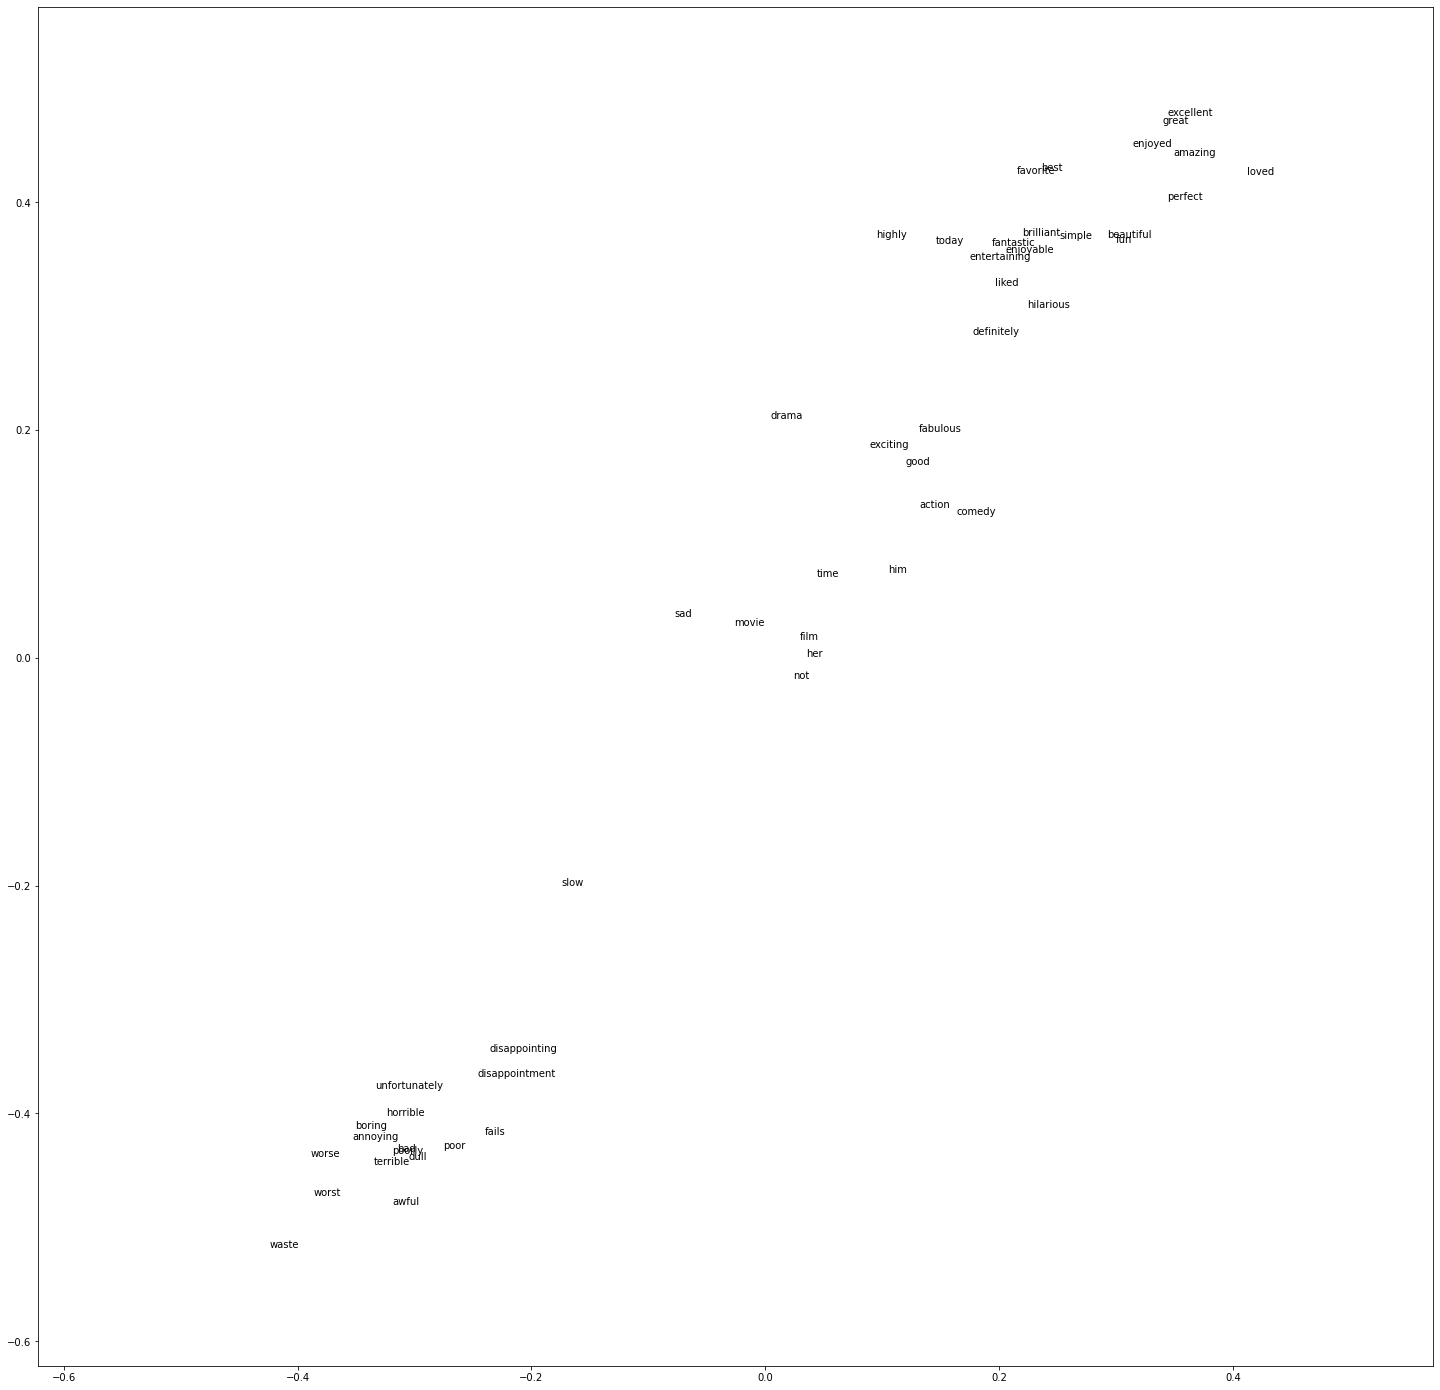

In [ ]:
for word in informative_terms:
  word_num = word_index[word]
  embeddings = embedding_matrix[word_num]
  plt.text(embeddings[0], embeddings[1], word)

# Do a little set-up to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (25, 25)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show()

We can see that positive words tend to cluster around each, other and negative words tend to cluster around each other.

## Final Test

Let's see how our model performs on the holdout dataset.

In [ ]:
predictions = model.predict(test_data)
predictions

array([[0.43552172],
       [0.99037814],
       [0.8708863 ],
       ...,
       [0.2065554 ],
       [0.49000606],
       [0.41394055]], dtype=float32)

The prediction values that we get are floating point numbers, but we want to convert these to a prediction of `0` for negative and `1` for positive. One way to do this is to simply round.

In [ ]:
predictions = [int(round(prediction)) for prediction in predictions.flatten()]
predictions[:10]

[0, 1, 1, 0, 1, 0, 1, 0, 1, 1]

And now we can measure our model quality.

In [ ]:
precision = tf.keras.metrics.Precision()
precision.update_state(test_labels, predictions)

recall = tf.keras.metrics.Recall()
recall.update_state(test_labels, predictions)

print('Precision: {}, Recall: {}'.format(
    precision.result().numpy(), recall.result().numpy()))

Precision: 0.8548285961151123, Recall: 0.8738399744033813


# Exercises

## Exercise 1

What structures do you see in the embeddings of the words that were visualized earlier in this lab?

### **Student Solution**

*The two dimensional embeddings are nearly symmetric so that they follow a progression similar to the linear function x=y as shown by the informative terms graph.*



---

## Exercise 2: Higher-Dimensional Embeddings

Now we can visualize two-dimensional embeddings, but recall that our original vocabulary had over 80,000 words; we're missing a lot of information if we only use two dimensions!

Typical embedding dimensions are 50, 100, 200, 300, and sometimes even larger.

Retrain our earlier model with the same hyperparameters, using **50-dimensional** embeddings and retrieve the learned embeddings from this trained model. You should observe a slower training time and much higher training accuracy after 10 epochs.

Print out the precision and recall on the testing holdout data.

### **Student Solution**

In [ ]:
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# only uncomment one of these depending on whether you want top 25 words
from tensorflow import keras

imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data()

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

# imdb = keras.datasets.imdb

# (train_data, train_labels), (test_data, test_labels) = imdb.load_data(
#     skip_top=25,)

# train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

((25000,), (25000,), (25000,), (25000,))

In [ ]:
maxlen = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, value=word_index["<PAD>"], padding='post', maxlen=maxlen)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, value=word_index["<PAD>"], padding='post', maxlen=maxlen)

## changed from 2 to 50
embedding_dim = 50
## changed from 2 to 50

embedding_layer = keras.layers.Embedding(vocab_size, embedding_dim)

model = keras.Sequential([
  keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation='sigmoid')
])

# model.summary()

model.compile(
  # Calculate loss for a binary classification problem.
  loss='binary_crossentropy',

  # Adam is one of the most commonly used optimizers.
  optimizer=tf.keras.optimizers.Adam(),

  # We will only track accuracy for this task.
  metrics=['accuracy']
)

history = model.fit(
    train_data,
    train_labels,
    epochs=10,
    batch_size=512,
    validation_split=0.2
)

Epoch 1/10
40/40 [==============================] - 5s 118ms/step - loss: 0.6891 - accuracy: 0.5486 - val_loss: 0.6662 - val_accuracy: 0.6560
Epoch 2/10
40/40 [==============================] - 5s 114ms/step - loss: 0.5626 - accuracy: 0.7901 - val_loss: 0.4759 - val_accuracy: 0.8038
Epoch 3/10
40/40 [==============================] - 5s 114ms/step - loss: 0.3382 - accuracy: 0.8899 - val_loss: 0.3460 - val_accuracy: 0.8642
Epoch 4/10
40/40 [==============================] - 5s 114ms/step - loss: 0.2116 - accuracy: 0.9391 - val_loss: 0.3053 - val_accuracy: 0.8768
Epoch 5/10
40/40 [==============================] - 5s 113ms/step - loss: 0.1432 - accuracy: 0.9649 - val_loss: 0.2867 - val_accuracy: 0.8850
Epoch 6/10
40/40 [==============================] - 5s 114ms/step - loss: 0.0997 - accuracy: 0.9800 - val_loss: 0.2828 - val_accuracy: 0.8850
Epoch 7/10
40/40 [==============================] - 5s 116ms/step - loss: 0.0711 - accuracy: 0.9893 - val_loss: 0.2843 - val_accuracy: 0.8846
Epoch 

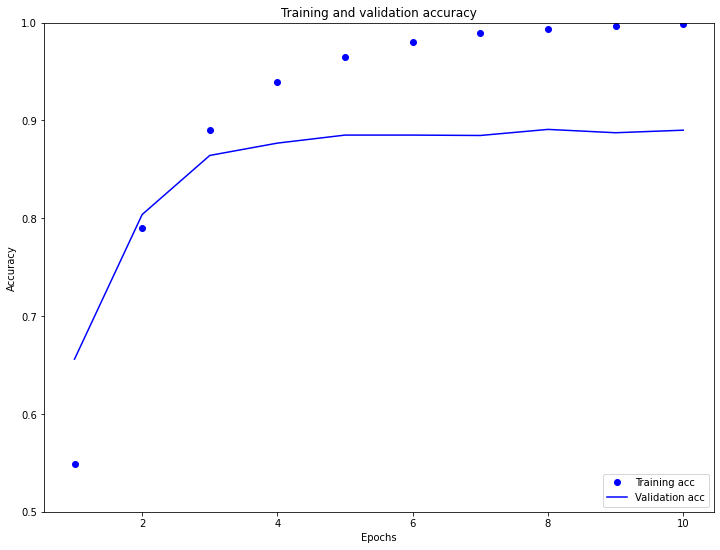

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))

plt.show()

In [ ]:
precision = tf.keras.metrics.Precision()
precision.update_state(test_labels, predictions)

recall = tf.keras.metrics.Recall()
recall.update_state(test_labels, predictions)

print('Precision: {}, Recall: {}'.format(
    precision.result().numpy(), recall.result().numpy()))

Precision: 0.8548285961151123, Recall: 0.8738399744033813


## Exercise 3: Embedding Projector

In this section we'll introduce the [Embedding Projector](http://projector.tensorflow.org/), a tool to visualize high-dimensional embeddings.

We will now write the embeddings to disk. To use the Embedding Projector, we will upload two files in tab separated format: a file of vectors (containing the embeddings) and a file of metadata (containing the words). We will again only analyze our small set of terms from above.

Run the code block below to create the files necessary for the Embedding Projector.

In [ ]:
import io

e = model.layers[0]
embedding_matrix = e.get_weights()[0]

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word in informative_terms:
  word_num = word_index[word]
  embeddings = embedding_matrix[word_num]

  out_m.write(word.encode("utf-8").decode("utf-8")  + "\n")
  out_v.write('\t'.join(
      [str(x).encode("utf-8").decode("utf-8") for x in embeddings]) + "\n")

out_v.close()
out_m.close()

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>




Finally, open the [Embedding Projector](http://projector.tensorflow.org/):

*   Click on "Load" in the Data panel.
*   Upload the two files we created above: `vecs.tsv` and `meta.tsv`.

The embeddings we have trained will now be displayed. You can search for words to find their closest neighbors.

*Note: Your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.*

### Question 1

How do the structures of these embeddings compare to the two-dimensional embeddings we visualized earlier?

**Student Solution**

> *There is no longer a simple linear x=y arrangement of positive and negative words. While positive and negative words are still at opposite polls, additional words like film and movie are grouped together and not located on the same 3D line as positive and negative words. There are also clear outlier words such as time and action which have a slight bias towards positive or negative, but are separate from the positive and negative clusters*

---

### Question 2

List at least `5` words that seem to add little value to the sentiment analysis.

**Student Solution**

> 1. *Him*
> 1. *Her*
> 1. *Film*
> 1. *Movie*
> 1. *Time*